In [1]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dhoot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dhoot\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [186]:
data = pd.read_csv('Airline_reviews.csv')

In [187]:
data.shape

(23171, 20)

In [188]:
data.isnull().sum()

Sr No                         0
Airline Name                  0
Overall_Rating                0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  16042
Type Of Traveller          3738
Seat Type                  1096
Route                      3828
Date Flown                 3754
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
Recommended                   0
dtype: int64

In [189]:
# Split sentences and explode
data['split_review'] = data['Review'].str.split('.')
data = data.explode('split_review')

# Remove leading and trailing whitespaces
data['split_review'] = data['split_review'].str.strip()

# Remove empty strings
data = data[data['split_review'] != '']

# Reset index
data.reset_index(drop=True, inplace=True)

In [190]:
def clean_text(df, column_name):
    # Create a new DataFrame to avoid modifying the original one
    df_cleaned = df.copy()
    
    # Create a new column for the preprocessed text
    new_column_name = column_name + '_cleaned'
    df_cleaned[new_column_name] = df_cleaned[column_name]

    # Lowercase the text
    df_cleaned[new_column_name] = df_cleaned[new_column_name].str.lower()

    # Remove punctuation and non-alphabetic characters
    pattern = r'[^a-zA-Z\s.]|[' + re.escape(string.punctuation) + ']'
    df_cleaned[new_column_name] = df_cleaned[new_column_name].apply(lambda x: re.sub(pattern, '', x))
    
    # Tokenization
    df_cleaned[new_column_name] = df_cleaned[new_column_name].apply(word_tokenize)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    df_cleaned[new_column_name] = df_cleaned[new_column_name].apply(lambda x: [word for word in x if word not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    df_cleaned[new_column_name] = df_cleaned[new_column_name].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    # Join tokens back into a string
    df_cleaned[new_column_name] = df_cleaned[new_column_name].apply(lambda x: ' '.join(x))

    return df_cleaned




In [191]:
# Clean the 'split_review' column
df_cleaned = clean_text(data, 'split_review')

In [192]:
df_cleaned_final = clean_text(df_cleaned, 'Review')

In [193]:
df_cleaned_final.head(2)

,Sr No,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,...,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended,split_review,split_review_cleaned,Review_cleaned
0,0,Delta Airlines,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,...,5.0,4.0,4.0,NaN,NaN,3.0,yes,Moroni to Moheli,moroni moheli,moroni moheli turned pretty decent airline onl...
1,0,Delta Airlines,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,...,5.0,4.0,4.0,NaN,NaN,3.0,yes,Turned out to be a pretty decent airline,turned pretty decent airline,moroni moheli turned pretty decent airline onl...


In [195]:
sentiment_df =  df_cleaned_final[['Review_cleaned','split_review_cleaned']]

In [194]:
sentiment_df.shape

(192019, 4)

In [196]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [197]:
# Function to get sentiment score using VADER
def get_sentiment_score(text):
    scores = sid.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Applying sentiment analysis to each column
for column in sentiment_df.columns:
    sentiment_df[column + '_sentiment'] = sentiment_df[column].apply(get_sentiment_score)



C:\Users\Dhoot\AppData\Local\Temp\ipykernel_23268\2493281052.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df[column + '_sentiment'] = sentiment_df[column].apply(get_sentiment_score)
C:\Users\Dhoot\AppData\Local\Temp\ipykernel_23268\2493281052.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df[column + '_sentiment'] = sentiment_df[column].apply(get_sentiment_score)


In [198]:
df1 = df_cleaned_final

In [199]:
sentiment_df.shape

(192019, 4)

In [200]:
df1 = pd.concat([df1, sentiment_df[['split_review_cleaned_sentiment']]], axis=1, join='outer')
df1.shape

(192019, 24)

In [201]:
df1.tail(2)

,Sr No,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,...,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended,split_review,split_review_cleaned,Review_cleaned,split_review_cleaned_sentiment
192017,23170,American Airlines,1,"""lost all of our money with no refund""",20th May 2022,True,They lied about connection in Narita and we ...,NaN,Solo Leisure,Economy Class,...,NaN,1.0,NaN,NaN,1.0,no,Nor did they advise of such at purchase,advise purchase,lied connection narita lost money refund agree...,neutral
192018,23170,American Airlines,1,"""lost all of our money with no refund""",20th May 2022,True,They lied about connection in Narita and we ...,NaN,Solo Leisure,Economy Class,...,NaN,1.0,NaN,NaN,1.0,no,Lost $1000 with this airline,lost airline,lied connection narita lost money refund agree...,negative


In [202]:
df2 = df1[['Verified', 'Type Of Traveller',
       'Seat Type', 'Seat Comfort',
       'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
       'Recommended', 'split_review_cleaned','split_review_cleaned_sentiment']]

In [203]:
df2.isnull().sum()

Verified                              0
Type Of Traveller                 26637
Seat Type                          7777
Seat Comfort                      29625
Cabin Staff Service               30464
Food & Beverages                  67442
Ground Service                    34184
Recommended                           0
split_review_cleaned                  0
split_review_cleaned_sentiment        0
dtype: int64

In [204]:
df2.shape

(192019, 10)

In [205]:
df2.tail(2)

,Verified,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Recommended,split_review_cleaned,split_review_cleaned_sentiment
192017,True,Solo Leisure,Economy Class,NaN,NaN,NaN,1.0,no,advise purchase,neutral
192018,True,Solo Leisure,Economy Class,NaN,NaN,NaN,1.0,no,lost airline,negative


In [206]:
# we cannot find these columns to fill up with nor we have enough data to apply any business sense here. So dropping here makes sense, filling up with mean in this is not making sense. Could use seat comfort rating but again that is also empty in many cases so dropping is correct here in this case
df3 = df2.dropna(subset=['Seat Type','Type Of Traveller'])
df3 = df3.reset_index()
df3.isnull().sum()

index                                 0
Verified                              0
Type Of Traveller                     0
Seat Type                             0
Seat Comfort                      13739
Cabin Staff Service               14578
Food & Beverages                  51529
Ground Service                     7596
Recommended                           0
split_review_cleaned                  0
split_review_cleaned_sentiment        0
dtype: int64

In [207]:
df3['Recommended'] = df3['Recommended'].replace({'yes':1,'no':0})
df3['Verified'] = df3['Verified'].astype(int)


In [208]:
df3.tail(2)

,index,Verified,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Recommended,split_review_cleaned,split_review_cleaned_sentiment
165353,192017,1,Solo Leisure,Economy Class,NaN,NaN,NaN,1.0,0,advise purchase,neutral
165354,192018,1,Solo Leisure,Economy Class,NaN,NaN,NaN,1.0,0,lost airline,negative


In [209]:
def fillna_groupby_mean(df, groupby_cols, rating_cols):
    """
    Fill missing values in rating columns based on groupby columns using mean imputation.
    
    Parameters:
        df (DataFrame): The input DataFrame.
        groupby_cols (list): List of columns to group by.
        rating_cols (list): List of rating columns to fill missing values.
    
    Returns:
        DataFrame: DataFrame with missing values filled based on groupby columns using mean imputation.
    """
    # Iterate over each rating column
    for rating_col in rating_cols:
        # Fill missing values in each rating column based on groupby columns using mean imputation
        df[rating_col] = df.groupby(groupby_cols)[rating_col].transform(lambda x: x.fillna(x.mean()))
    
    return df

# Columns to group by
groupby_cols = ['Seat Type', 'Recommended', 'Type Of Traveller']

# Rating columns to fill missing values
rating_cols = ['Seat Comfort', 'Cabin Staff Service','Food & Beverages','Ground Service']

# Applying the function to fill missing values
df_filled = fillna_groupby_mean(df3, groupby_cols, rating_cols)


In [210]:
df_filled.isnull().sum()

index                             0
Verified                          0
Type Of Traveller                 0
Seat Type                         0
Seat Comfort                      0
Cabin Staff Service               0
Food & Beverages                  0
Ground Service                    0
Recommended                       0
split_review_cleaned              0
split_review_cleaned_sentiment    0
dtype: int64

In [211]:
one_hot_encoded_df = pd.get_dummies(df_filled[['Type Of Traveller', 'Seat Type']], prefix='category')

one_hot_encoded_df = one_hot_encoded_df.astype(int)

# Concatenating the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df_filled.drop(columns=['Type Of Traveller', 'Seat Type']), one_hot_encoded_df], axis=1)



In [212]:
df_filled.tail(2)

,index,Verified,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Recommended,split_review_cleaned,split_review_cleaned_sentiment
165353,192017,1,Solo Leisure,Economy Class,1.852794,2.015009,1.690511,1.0,0,advise purchase,neutral
165354,192018,1,Solo Leisure,Economy Class,1.852794,2.015009,1.690511,1.0,0,lost airline,negative


In [213]:
df_encoded.head(5)

,index,Verified,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Recommended,split_review_cleaned,split_review_cleaned_sentiment,category_Business,category_Couple Leisure,category_Family Leisure,category_Solo Leisure,category_Business Class,category_Economy Class,category_First Class,category_Premium Economy
0,0,1,4.0,5.0,4.0,4.0,1,moroni moheli,neutral,0,0,0,1,0,1,0,0
1,1,1,4.0,5.0,4.0,4.0,1,turned pretty decent airline,positive,0,0,0,1,0,1,0,0
2,2,1,4.0,5.0,4.0,4.0,1,online booking worked well checkin boarding fi...,positive,0,0,0,1,0,1,0,0
3,3,1,4.0,5.0,4.0,4.0,1,short flight minute didnt expect much still ma...,positive,0,0,0,1,0,1,0,0
4,4,1,4.0,5.0,4.0,4.0,1,flight time,neutral,0,0,0,1,0,1,0,0


<Axes: >

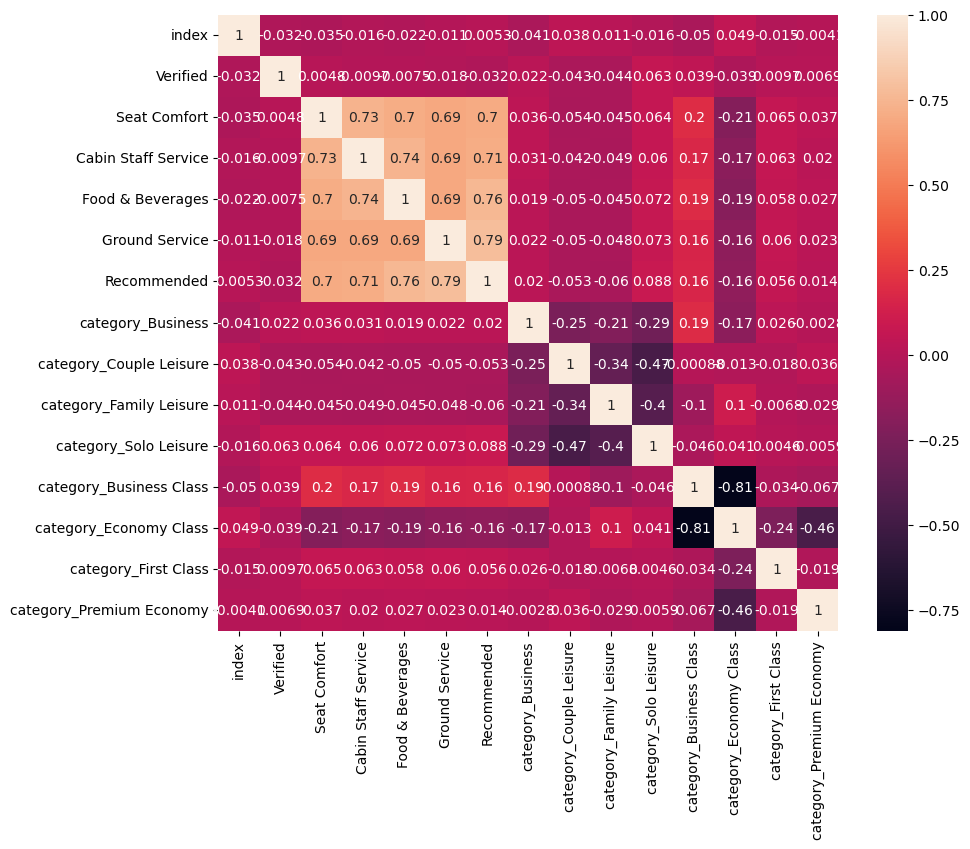

In [214]:
df_corr = df_encoded.drop(columns=['split_review_cleaned','split_review_cleaned_sentiment'],axis=1)
plt.figure(figsize=(10, 8))

sns.heatmap(df_corr.corr(), annot = True)

In [215]:
df_encoded.shape

(165355, 17)

In [216]:
df_encoded.columns

Index(['index', 'Verified', 'Seat Comfort', 'Cabin Staff Service',
       'Food & Beverages', 'Ground Service', 'Recommended',
       'split_review_cleaned', 'split_review_cleaned_sentiment',
       'category_Business', 'category_Couple Leisure',
       'category_Family Leisure', 'category_Solo Leisure',
       'category_Business Class', 'category_Economy Class',
       'category_First Class', 'category_Premium Economy'],
      dtype='object')

In [217]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


# Separate numerical and text data

text_columns = ['split_review_cleaned','split_review_cleaned_sentiment']
non_text_columns = ['Verified', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Ground Service', 'Recommended', 'category_Business',
       'category_Couple Leisure', 'category_Family Leisure',
       'category_Solo Leisure', 'category_Business Class',
       'category_Economy Class', 'category_First Class',
       'category_Premium Economy']


numerical_data = df_encoded[non_text_columns]
text_data = df_encoded[text_columns]

# Preprocess numerical data
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Applying PCA to numerical data with desired amount of variance to retain
desired_variance_ratio = 0.95  # Choosing the desired cumulative explained variance ratio
pca = PCA(n_components=desired_variance_ratio)
numerical_data_pca = pca.fit_transform(numerical_data_scaled)

# Combine PCA-transformed numerical data with text data
numerical_data_pca_df = pd.DataFrame(numerical_data_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
combined_data = pd.concat([numerical_data_pca_df, text_data], axis=1)

# explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# cumulative explained variance ratio
print("Cumulative explained variance ratio:", sum(pca.explained_variance_ratio_))

# shape of the PCA-transformed numerical data
print("Shape of transformed numerical data:", numerical_data_pca.shape)

# combined DataFrame
print("Combined DataFrame:")
print(combined_data)


Explained variance ratio: [0.2898416  0.13537544 0.10505783 0.09504208 0.0834153  0.07216873
 0.06992483 0.0692168  0.02633648 0.02171848]
Cumulative explained variance ratio: 0.9680975687156781
Shape of transformed numerical data: (165355, 10)
Combined DataFrame:
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       2.816749 -1.571006  1.207761 -0.401987 -0.084619 -0.055065 -0.491050   
1       2.816749 -1.571006  1.207761 -0.401987 -0.084619 -0.055065 -0.491050   
2       2.816749 -1.571006  1.207761 -0.401987 -0.084619 -0.055065 -0.491050   
3       2.816749 -1.571006  1.207761 -0.401987 -0.084619 -0.055065 -0.491050   
4       2.816749 -1.571006  1.207761 -0.401987 -0.084619 -0.055065 -0.491050   
...          ...       ...       ...       ...       ...       ...       ...   
165350  2.157340  3.641757  0.389303  1.242917 -1.985103 -0.410259 -0.362825   
165351 -1.255685 -0.520428  1.709024 -0.330441 -0.036686 -0.000105 -0.479820   
165352 -1.25568

<Axes: >

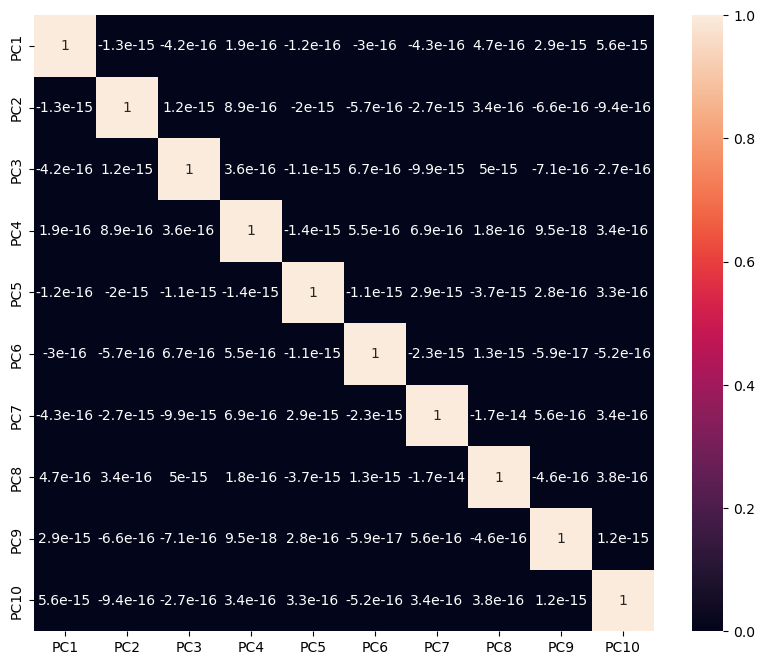

In [218]:
# Correlation visualization post the PCA implementation
df_corr = combined_data.drop(columns=['split_review_cleaned','split_review_cleaned_sentiment'],axis=1)
plt.figure(figsize=(10, 8))

sns.heatmap(df_corr.corr(), annot = True)

In [219]:
# Train test Split
X  = combined_data.drop(columns=['split_review_cleaned_sentiment'])
y = combined_data['split_review_cleaned_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [220]:
combined_data.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'split_review_cleaned', 'split_review_cleaned_sentiment'],
      dtype='object')

In [221]:
# 'text_columns' contains the names of text columns and 'non_text_columns' contains the names of non-text columns
text_columns = 'split_review_cleaned'
non_text_columns = ['PC1','PC2','PC3','PC4','PC5','PC5','PC6','PC7','PC8','PC9','PC10']

X_train_text = X_train[text_columns]
X_train_non_text = X_train[non_text_columns]

X_test_text = X_test[text_columns]
X_test_non_text = X_test[non_text_columns]


In [157]:
X.isnull().sum()

PC1                     0
PC2                     0
PC3                     0
PC4                     0
PC5                     0
PC6                     0
PC7                     0
PC8                     0
PC9                     0
PC10                    0
split_review_cleaned    0
dtype: int64

In [222]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)

# Transform the testing text data
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

In [223]:
from scipy.sparse import hstack
# Combine TF-IDF features with non-text features for training set
X_train_combined = hstack((X_train_tfidf, X_train_non_text))

# Combine TF-IDF features with non-text features for testing set
X_test_combined = hstack((X_test_tfidf, X_test_non_text))

In [224]:
type(X_test_combined)

scipy.sparse._coo.coo_matrix

# Random Forest

In [164]:
# Training random forest model
model = RandomForestClassifier(n_estimators=20, random_state=42)
model.fit(X_train_combined, y_train)

# Evaluating the model
y_pred = model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8350518581234314
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.78      0.81      9435
     neutral       0.82      0.93      0.87     13180
    positive       0.85      0.76      0.81     10456

    accuracy                           0.84     33071
   macro avg       0.84      0.83      0.83     33071
weighted avg       0.84      0.84      0.83     33071



# Cross Validation Using Random Forest for Best Fit Model

In [165]:
from sklearn.model_selection import cross_val_score

# List of n_estimators values to try
n_estimators_values = [10, 20, 30, 40, 50]

# Dictionary to store cross-validation results
cv_results = {}

# Performing cross-validation for each value of n_estimators
for n_estimators in n_estimators_values:
    # Initialize Random Forest classifier with current n_estimators value
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train_combined, y_train, cv=5, scoring='accuracy')
    
    # Store mean cross-validation score
    cv_results[n_estimators] = cv_scores.mean()

# cross-validation results
print("Cross-Validation Results:")
for n_estimators, cv_score in cv_results.items():
    print(f"n_estimators={n_estimators}: Mean Accuracy = {cv_score:.4f}")

# Choosing the best value of n_estimators based on cross-validation results
best_n_estimators = max(cv_results, key=cv_results.get)
print("Best n_estimators:", best_n_estimators)

# Training a Random Forest classifier with the best value of n_estimators
best_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
best_model.fit(X_train_combined, y_train)

# Evaluating the best model on the test set
y_pred = best_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("\nBest Model Evaluation:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Cross-Validation Results:
n_estimators=10: Mean Accuracy = 0.8030
n_estimators=20: Mean Accuracy = 0.8246
n_estimators=30: Mean Accuracy = 0.8347
n_estimators=40: Mean Accuracy = 0.8399
n_estimators=50: Mean Accuracy = 0.8425
Best n_estimators: 50

Best Model Evaluation:
Accuracy: 0.8486589459042666
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.79      0.82      9435
     neutral       0.84      0.94      0.88     13180
    positive       0.86      0.79      0.83     10456

    accuracy                           0.85     33071
   macro avg       0.85      0.84      0.84     33071
weighted avg       0.85      0.85      0.85     33071



In [172]:
y_labels_df = pd.DataFrame(y_test).reset_index()
y_labels_df.head(2)

,index,split_review_cleaned_sentiment
0,146713,neutral
1,109812,negative


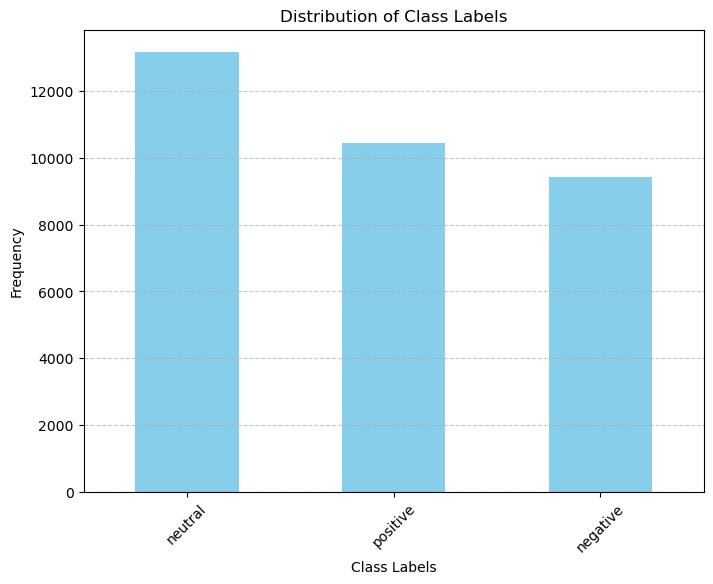

In [175]:
import pandas as pd
import matplotlib.pyplot as plt


class_counts = y_labels_df['split_review_cleaned_sentiment'].value_counts()

# Plotting the distribution of class labels
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Class Labels')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


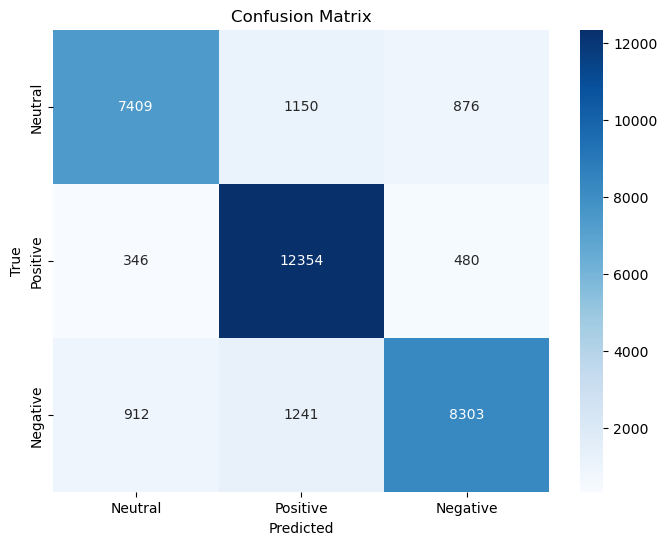

In [179]:
# from above distribution we can understand the order of the labels in confusion matrix to use so we do not confuse ourselves to 
# misinterpret the results with incorrect results

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

class_names = ['Neutral', 'Positive','Negative']

# Displaying confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Not using Naive Bayes as it does not allow sparse matrix as input and converting it to array will only make processing locally the array data be too much of load.

Sparse matrices are used to efficiently store and manipulate large matrices with a significant number of zero values. They only store the non-zero values and their corresponding indices, resulting in lower memory usage and faster computations for certain operations compared to dense matrices.

Converting a sparse matrix to a dense array can significantly increase memory usage, especially if the matrix is large and has many zero values. It also requires more computational resources for operations because it needs to allocate memory for each element in the array.

In [229]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 487.6 kB/s eta 0:03:25
   ---------------------------------------- 0.2/99.8 MB 1.3 MB/s eta 0:01:16
   ---------------------------------------- 1.1/99.8 MB 6.3 MB/s eta 0:00:16
   - -------------------------------------- 3.2/99.8 MB 15.8 MB/s eta 0:00:07
   -- ------------------------------------- 5.3/99.8 MB 21.0 MB/s eta 0:00:05
   -- ------------------------------------- 6.5/99.8 MB 22.8 MB/s eta 0:00:05
   -- ------------------------------------- 6.5/99.8 MB 22.8 MB/s eta 0:00:05
   --- ------------------------------------ 8.8/99.8 MB 22.4 MB/s eta 0:00:05
   ----- -----------------------

In [234]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

y_train_cat = y_train.astype('category')
y_test_cat = y_test.astype('category')
y_train_int = y_train_cat.cat.codes
y_test_int = y_test_cat.cat.codes

# List of n_estimators values to try
n_estimators_values = [10, 20, 30, 40, 50]

# Dictionary to store cross-validation results
cv_results = {}

# Performing cross-validation for each value of n_estimators
for n_estimators in n_estimators_values:
    # Initialize XGBoost classifier with current n_estimators value
    model = xgb.XGBClassifier(n_estimators=n_estimators, random_state=42)
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train_combined, y_train_int, cv=5, scoring='accuracy')
    
    # Store mean cross-validation score
    cv_results[n_estimators] = cv_scores.mean()

# Cross-validation results
print("Cross-Validation Results:")
for n_estimators, cv_score in cv_results.items():
    print(f"n_estimators={n_estimators}: Mean Accuracy = {cv_score:.4f}")

# Choosing the best value of n_estimators based on cross-validation results
best_n_estimators = max(cv_results, key=cv_results.get)
print("Best n_estimators:", best_n_estimators)

# Training an XGBoost classifier with the best value of n_estimators
best_model = xgb.XGBClassifier(n_estimators=best_n_estimators, random_state=42)
best_model.fit(X_train_combined, y_train_int)

# Evaluating the best model on the test set
y_pred = best_model.predict(X_test_combined)
accuracy = accuracy_score(y_test_int, y_pred)
report = classification_report(y_test_int, y_pred)
print("\nBest Model Evaluation:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
